# Residual Network para Separação de sinais LTE e WiFi

### Primeiramente iremos importar todas as bibliotecas necessárias para criação do modelo.

O modelo da Residual Network (ResNet) será feito utilizando as bibliotecas Keras e Tensorflow. <br>Também utilizaremos as bibliotecas Scikit Learning, Numpy, Matplotlib e Seaborn para realizar alguns tratamentos nos dados e visualização de resultados. 

In [22]:
#Author: Gefferson Mateus da Rocha Simão
#Import libraries
#Numpy
import numpy as np

# Keras 
import tensorflow as tf
import keras
from keras.utils import to_categorical
from keras.models import Model, load_model
from keras.initializers import glorot_uniform
from keras.layers import *

#Scikit Learng
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Seaborn and Matplotlib
from seaborn import heatmap
from matplotlib import pyplot as plt

### Agora iremos carregar os dados que utilizaremos para criar o modelo

Serão utilizado dados I/Q de sinais de rádio. Sendo 3 conjuntos de tamanho (100000000, 1), contendo cada um um tipo sinal de rádio:<br>
<ul>
    <li>WiFi => Conjunto de dados contendo sinais I/Q em um canal com tráfego de dados Wifi.
    <li>LTE => Conjunto de dados contendo sinais I/Q em um canal com tráfego de dados LTE.
    <li>Clear => Conjunto de dados contendo sinais I/Q de um canal sem presença de tráfego de dados (Ruído).
<ul>

In [2]:
# Loading Data
wifi = np.load("E:/DADOS/wifi.npy")
lte = np.load("E:/DADOS/lte.npy")          
clear = np.load("E:/DADOS/clear.npy")

print('Tamanho dos dados WIFi:', np.shape(wifi))
print('Tamanho dos dados LTE:', np.shape(lte))
print('Tamanho dos dados Clear:', np.shape(clear))

Tamanho dos dados WIFi: (100000000, 1)
Tamanho dos dados LTE: (100000000, 1)
Tamanho dos dados Clear: (100000000, 1)


Agora que carregamos os dados, iremos juntar os dados dos três sinais I/Q em um única matriz com as partes reais e imaginárias em colunas diferentes. 

In [3]:
data = np.concatenate((wifi, lte, clear)) # Juntando os dados em um único vetor (300000000, 1)

#Reshaping data 
data = np.hstack([np.real(data) , np.imag(data)]) #Colocando as componentes em fase e quadratura em colunas separadas.
print('Novo vetor de dados tem tamanho',np.shape(data))
#print(data) #Print dos dados

Novo vetor de dados tem tamanho (300000000, 2)


Foi a transformação dos dados utilizando o StandardScaler

In [4]:
scaler = StandardScaler()
print(scaler.fit(data))
#StandardScaler()
print(scaler.mean_)
data = scaler.transform(data)
print(data)

StandardScaler()
[-4.23106311e-07 -1.13802925e-07]
[[-8.0229771e-01  7.8227025e-01]
 [-6.0102570e-01  2.3453536e+00]
 [-6.0102570e-01 -1.9465685e-01]
 ...
 [-6.0102570e-01  7.2858576e-04]
 [-6.0102570e-01 -7.8081316e-01]
 [ 8.0787855e-01  7.2858576e-04]]


Iremos então realizar um *reshape* dos dados, de forma que teremos um Input na ResNet com 20000 dados de um tipo de sinal.

In [5]:
input_size = 20000 #Tamanho do Input que iremos utilizar na rede neural.
data = data.reshape([-1, input_size, 2]) # Reshape dos dados
print('Tamanho dos dados após o Reshape:', np.shape(data))
#print(data)

Tamanho dos dados após o Reshape: (15000, 20000, 2)


### Criando Labels dos dados

Para criar os labels iremos apenas criar os labels = {0,1,2} para os dados onde:
<ul>
    <li>WiFi = 0
    <li>LTE = 1
    <li>Clear = 2
<ul>

In [6]:
#Creating Labels
fraq = int(np.shape(data)[0]/3)
label = np.zeros(len(data))
label[fraq:fraq*2] = 1
label[fraq*2:fraq*3] = 2 
print(f'Formato do vetor de dados: {np.shape(data)}')
print(f'Tamanho do vetor de labels: {np.shape(label)}')

Formato do vetor de dados: (15000, 20000, 2)
Tamanho do vetor de labels: (15000,)


### Separando Conjunto de Dados

Foi realizado a separação do conjunto de dados da seguinte forma:
<ul>
    <li>Treino: 60%
    <li>Validação: 20%
    <li>Teste: 20%
<ul>

In [7]:
#dividindo dados em treinamento e teste

X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.2, random_state=42)

X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.25, random_state=42)


print(f'Tamanho do dados de treinamento: {np.shape(X_train)}')
print(f'Tamanho do dados de teste: {np.shape(X_test)}')
print(f'Tamanho do dados de validação: {np.shape(X_validation)}\n')

print(f'Tamanho do labels de treinamento: {np.shape(y_train)}')
print(f'Tamanho do labels de teste: {np.shape(y_test)}')
print(f'Tamanho do labels de validação: {np.shape(y_validation)}')



Tamanho do dados de treinamento: (9000, 20000, 2)
Tamanho do dados de teste: (3000, 20000, 2)
Tamanho do dados de validação: (3000, 20000, 2)

Tamanho do labels de treinamento: (9000,)
Tamanho do labels de teste: (3000,)
Tamanho do labels de validação: (3000,)


Realizando a conversão dos labels para uma matriz com labels One Hot Encoded


In [8]:
#Realizando a conversão dos labels para uma matriz com labels One Hot Encoded
y_train = tf.one_hot(y_train, depth=3)
y_test = tf.one_hot(y_test, depth=3)
y_validation = tf.one_hot(y_validation, depth=3)

print(y_train)
print(y_test)
print(y_validation)

tf.Tensor(
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]], shape=(9000, 3), dtype=float32)
tf.Tensor(
[[0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]], shape=(3000, 3), dtype=float32)
tf.Tensor(
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]], shape=(3000, 3), dtype=float32)


## Agora Iremos criar o Residual Stack
 Cada Residual Stack consiste de um block convolucional Linear duas dois blocos residuais que depois passam por uma cadada de MaxPooling diminuindo a dimensão pela metade.
<br> O modelo do Redisual Stack segue como na figura abaixo: <br>
 ![_imag_error_](Residual_Stack.png "Residual Stack [1]")
<br>[1] Residual Unit and Residual Stack (source: *Over the Air Deep Learning
Based Radio Signal Classification*)


In [9]:
# Creating and ResidualStack 
def ResidualStack(x, f, poolsize = 2):
    
    #1x1 Linear Convolution
    
    x = Conv1D(f, 1, strides = 1, padding='same', data_format='channels_last')(x)
    x = Activation('linear')(x)
    
    #Residual Unit 1

    x_skip = x
    x = Conv1D(f, 3, strides=1, padding='same', data_format='channels_last')(x)
    x = Activation('relu')(x)
    x = Conv1D(f, 3, strides=1, padding='same', data_format='channels_last')(x)
    x = Activation('linear')(x)
    
    
    #Skip conection
    
    if x.shape[1:] == x_skip.shape[1:]:
       # x = add()([x, x_skip])
        x = x + x_skip
    else:
        raise Exception('Error: Failed Skip Connection')
        
    # Residual Unit 2
    x_skip = x
    x = Conv1D(f, 3, strides=1, padding='same', data_format='channels_last')(x)
    x = Activation('relu')(x)
    x = Conv1D(f, 3, strides=1, padding='same', data_format='channels_last')(x)
    x = Activation('linear')(x)
    
    
    #Skip conection
    
    if x.shape[1:] == x_skip.shape[1:]:
       # x = add()([x, x_skip])
        x = x + x_skip
    else:
        raise Exception('Error: Failed Skip Connection')
    
    #MaxPooling
    
    x = MaxPooling1D(pool_size=poolsize, strides=None, padding='valid', data_format='channels_last')(x)
    
    return x


## Com a Residual Stack definida iremos então criar o modelo da ResNet:

<br> O modelo utilizado irá ter 4 filtros na rede neural convoluciona e aceitará um Input Inicial de 20000 dados. <br>
A cada entrada em um Residual Stack o Tamanho de Input é dividio pela metade pelo MaxPooling. <br>
Cada Camada Convolucional 1D dos Residual Stack têm 4 filtros cada.<br>
Após os Residual Stack os dados passaram por duas camadas densas com ativação Tangente Hiperbólica e uma cadada de output com ativação Softmax.
<br>

![_imag_error_](Model.png "ResNet Model [2]")
<br>[2] ResNet Model (source: *ChARM*: **NextG Spectrum Sharing Through
Data-Driven Real-Time O-RAN Dynamic Control**)

In [10]:
def ResNet(input_shape, classes = 3):
    
    x_input = Input(input_shape)
    x = x_input
    
    #MaxPooling
    
    x = MaxPooling1D(pool_size=2, strides=None, padding='valid', data_format='channels_last')(x)
    
    #ResidualStacks
    
    filters = 4
    
    #x = ResidualStack(x, filters, 2)
    x = ResidualStack(x, filters, 5)
    x = ResidualStack(x, filters, 2)
    x = ResidualStack(x, filters, 5)
    x = ResidualStack(x, filters, 2)
    x = ResidualStack(x, filters, 5)
    x = ResidualStack(x, filters, 2)
    
    #Output Layers
    
    x = Flatten()(x)
    x = Dense(16, activation='tanh',  kernel_initializer="he_normal")(x)
    x = Dropout(.5)(x)
    x = Dense(16, activation='tanh',  kernel_initializer="he_normal")(x)
    x = Dropout(.5)(x)
    x = Dense( classes, activation='softmax', kernel_initializer = glorot_uniform(seed=0))(x)
    
    model = Model(inputs= x_input, outputs = x)
    
    return model

In [11]:
#Building the Model
model = ResNet((20000, 2), 3)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 20000, 2)]   0           []                               
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 10000, 2)     0           ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 10000, 4)     12          ['max_pooling1d[0][0]']          
                                                                                                  
 activation (Activation)        (None, 10000, 4)     0           ['conv1d[0][0]']                 
                                                                                              

Iniciando os Parametros para treinamento do modelo

In [12]:
# initialize optimizer 
adm = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
#Number of epochs
num_epochs = 200
#Batch size
batch = 45


In [13]:
#Compile the model
model.compile(optimizer=adm, loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
history = model.fit(X_train, y_train, epochs = num_epochs, batch_size = batch, validation_data=(X_validation, y_validation))

Epoch 1/200
200/200 [==============================] - 24s 114ms/step - loss: 1.3794 - accuracy: 0.3273 - val_loss: 1.1037 - val_accuracy: 0.3687
Epoch 2/200
200/200 [==============================] - 23s 113ms/step - loss: 1.1319 - accuracy: 0.3670 - val_loss: 1.0388 - val_accuracy: 0.4973
Epoch 3/200
200/200 [==============================] - 23s 114ms/step - loss: 1.0033 - accuracy: 0.4872 - val_loss: 0.7702 - val_accuracy: 0.6733
Epoch 4/200
200/200 [==============================] - 23s 114ms/step - loss: 0.7891 - accuracy: 0.6188 - val_loss: 0.5801 - val_accuracy: 0.7067
Epoch 5/200
200/200 [==============================] - 23s 114ms/step - loss: 0.6107 - accuracy: 0.7084 - val_loss: 0.3739 - val_accuracy: 0.8293
Epoch 6/200
200/200 [==============================] - 23s 114ms/step - loss: 0.4559 - accuracy: 0.7701 - val_loss: 0.3321 - val_accuracy: 0.8317
Epoch 7/200
200/200 [==============================] - 23s 114ms/step - loss: 0.4226 - accuracy: 0.7830 - val_loss: 0.3311 -

## Resultado do Treinamento do Modelo

Abaixo vemos o resultado da curva da acurácia do modelo durante o treinamento.<br>
Vemos também o resultado da curva da acurácia obtida durante o treinamento para os dados de validação. 


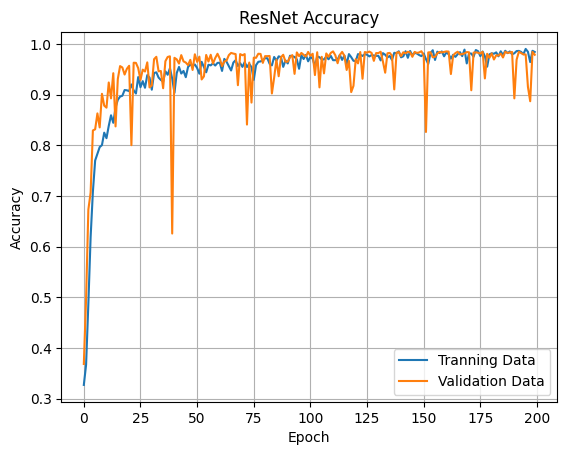

In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('ResNet Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.grid()
plt.legend(['Tranning Data', 'Validation Data'], loc='lower right')
plt.show()

Já no gráfico abaixo vemos como a curva da Função Objetivo (Loss) para os dados de treinamento e de validação

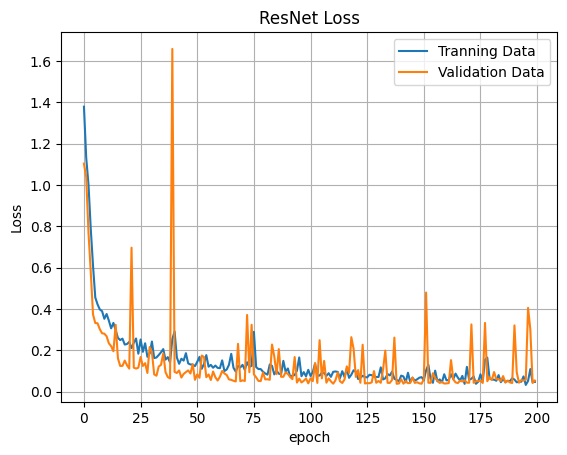

In [16]:
#Plotting the Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('ResNet Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.grid()
plt.legend(['Tranning Data', 'Validation Data'], loc='upper right')
plt.show()

# Avaliando o Modelo

Iremos verificar o resultados obtidos com o modelo ao inserirmos novos dados não vistos antes para testes

In [17]:
loss, acc = model.evaluate(X_test, y_test, batch_size=32)
print('AVALIANDO O MODELO COM OS DADOS DE TESTE:')
print('Acurácia aos dados de Test: ', str(round(acc*100, 2)), '%')
print('\n')

94/94 [==============================] - 2s 26ms/step - loss: 0.0584 - accuracy: 0.9787
AVALIANDO O MODELO COM OS DADOS DE TESTE:
Acurácia aos dados de Test:  97.87 %




### Criaremos uma Matriz de Confusão para melhor visualizarmos os resultados com os dados de testes
Primeiramente iremos prever as probabilidades para cada dado inserido no modelo e iremos associar a uma classe:

In [18]:
y_pred = model.predict(X_test) # Prevendo probabilidade
labels_pred = np.argmax(y_pred, axis=-1) #Associando a maior probabilidade como a classe correta.
print(labels_pred)

94/94 [==============================] - 3s 26ms/step
[2 1 2 ... 2 2 2]


Transformando de volta o vetor de labels de teste para um vetor os labels de sem o one hot encoded para utilizarmos na matrix de confusão

In [19]:
#Transformando de volta para um vetor os labels de sem one_hot_encoded para matrix de confusão
rounded_labels=np.argmax(y_test, axis=1)
rounded_labels[1]
print(rounded_labels)

[2 1 2 ... 2 2 2]


Matriz de Confusão

<Axes: >

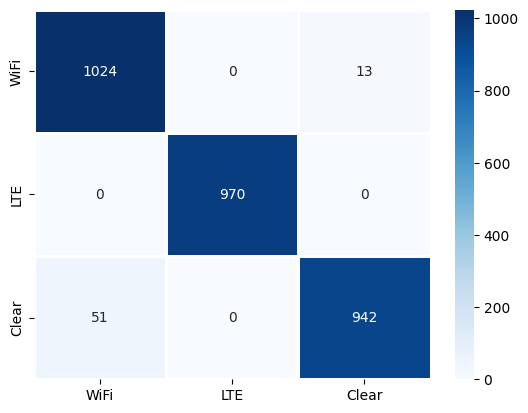

In [20]:

#Ploting a Matriz de Confusão
classes = ['WiFi', 'LTE', 'Clear']
cm = confusion_matrix(rounded_labels, labels_pred)
heatmap(cm, annot=True, linewidth=1, cmap='Blues', fmt=".0f", xticklabels=classes, yticklabels=classes)


### Salvando o Modelo

In [21]:
#model.save("resnet_model.h5")
#print("Saved model to disk")

Saved model to disk
